In [0]:
# Imports
from bs4 import BeautifulSoup
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from spacy.tokenizer import Tokenizer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import spacy
import squarify
import string


In [0]:
# Load NLP
nlp = spacy.load("en_core_web_lg")

# Read in CSV data
df = pd.read_csv('get_follower_data.csv')

# Alter the data
df['text'] = df['text'].apply(
    lambda x: x[2:-1].replace('\\n', ' ').replace('\n\n', ' ').replace(
        '\n', ' '))

###                                ###
# No idea why this was commented out #
###                                ###

# df['text'] = [BeautifulSoup(text).get_text() for text in df['text']]
# df.head()


In [0]:
# Create tokenizer
tokenizer = Tokenizer(nlp.vocab)

# Esablish stopwords
STOP_WORDS = nlp.Defaults.stop_words.union([' '])

# Esablish SPANISH stopwords
spanish_stop_words = ['de', 'e', 'la', 'le', 'que', 'y', 'el', 'un', 'r', 'en', 
                      'w', "it's", "it’s", 'u', "i'm"]

In [0]:
# Create tokens without stop, punct, pronouns or extended stop words

tokens = []

for doc in tokenizer.pipe(df['text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if ((token.is_stop == False) and (token.is_punct == False) and
            (token.pos_!= 'PRON') and token.text.lower() not in STOP_WORDS and
            token.text.lower() not in spanish_stop_words):

            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

# Make column of tokens
df['tokens'] = tokens

In [0]:
def count(docs):
  """
  When called on the tokens column, this shows which words are the most 
  popular in the corpus
  """

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

# Apply ^^ and see the top 20 words
wc = count(df['tokens'])
wc.head(20)

In [0]:
# See the top 20 words in squarify graph
wc_top20 = wc[wc['rank'] <= 20]
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.7 )
plt.axis('off')
plt.show()

## Word count per tweet

In [0]:
def tokenize(document):
  """
  Tokenize and lemma
  """
    
    doc = nlp(document)
    
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and
            (token.is_punct != True)]
            

In [0]:
# Tunning Parameters

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', 
                        ngram_range=(1,2),
                        max_df=.97,
                        min_df=3,
                        tokenizer=tokenize)

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(df['text']) # Similiar to fit_predict

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

$   -PRON-    1   100daysofcode    2   2014   2018   2020  \
0  0.127498  0.0  0.0      0.0  0.0             0.0  0.0    0.0    0.0    0.0   
1  0.103653  0.0  0.0      0.0  0.0             0.0  0.0    0.0    0.0    0.0   
2  0.000000  0.0  0.0      0.0  0.0             0.0  0.0    0.0    0.0    0.0   
3  0.000000  0.0  0.0      0.0  0.0             0.0  0.0    0.0    0.0    0.0   
4  0.000000  0.0  0.0      0.0  0.0             0.0  0.0    0.0    0.0    0.0   

   ...    🦋    🦠    🧐    🧠    🧡    🧢  🧢 https://t.co/8qi9mfljd  🧢 🧢    🧶  \
0  ...  0.0  0.0  0.0  0.0  0.0  0.0                       0.0  0.0  0.0   
1  ...  0.0  0.0  0.0  0.0  0.0  0.0                       0.0  0.0  0.0   
2  ...  0.0  0.0  0.0  0.0  0.0  0.0                       0.0  0.0  0.0   
3  ...  0.0  0.0  0.0  0.0  0.0  0.0                       0.0  0.0  0.0   
4  ...  0.0  0.0  0.0  0.0  0.0  0.0                       0.0  0.0  0.0   

   🧶 https://t.co/rahrmjbcu  
0                       0.0  
1                       0.0  
2                       0.0  
3                       0.0  
4                       0.0  

[5 rows x 10492 columns]

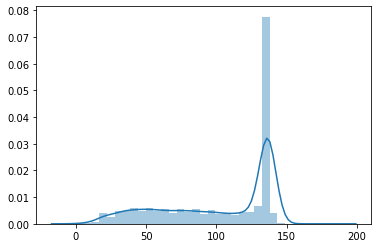

In [0]:
# Visualizing the lenth of characters.
doc_len = [len(doc) for doc in df['text']]

sns.distplot(doc_len);
 

## Sentiment Analysis


In [0]:
# Reread in the data
df = pd.read_csv('get_follower_data.csv')

# Train/test split
train, test = train_test_split(df.text, train_size = 0.5)


In [0]:
# Remove unwanted characters
REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
  """ Put the words back together"""
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train_clean = preprocess_reviews(train)
reviews_test_clean = preprocess_reviews(test)


In [0]:
# Vectorize
cv = CountVectorizer(binary=True)
cv.fit(reviews_train_clean)
X = cv.transform(reviews_train_clean)
X_test = cv.transform(reviews_test_clean)


In [0]:
# Assign target
target = [1 if i < 4080 else 0 for i in range(8161)]

# Create validation set
X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

# Score each string
for c in [0.01, 0.05, 0.25, 0.5, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_val, lr.predict(X_val))))
    

In [0]:
# Fit the model
final_model = LogisticRegression(C=0.05)
final_model.fit(X, target)
final_model = LogisticRegression(C=0.05)
final_model.fit(X, target)

# Print prediction
print ("Final Accuracy: %s" 
       % accuracy_score(target, final_model.predict(X_test)))


Final Accuracy: 0.5030020830780542


In [0]:
# Score each word
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
print('Positive')
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

print('Negative')
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)
    

Positive
('come', 0.37739485673234374)
('blog', 0.30891906869965635)
('still', 0.3001942623358227)
('ll', 0.2990590020961237)
('way', 0.27535262285660206)
Negative
('days', -0.4742626357977561)
('believe', -0.3519561329005742)
('times', -0.29235112701129595)
('didnt', -0.2594849867415561)
('companies', -0.24770755300989453)
